## Imports and dataset

In [1]:
from src.models.optimized_bnn import ClasBayesianNNVI
from src.attacks.distr_attacks_bnn_jax import mlmc_attack
from src.attacks.point_attacks_jax import attack

from src.utils import plot_ppds

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

## MNIST - DE

In [5]:
# load MNIST data without tensorflow
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.values, mnist.target.values
X = jnp.array(X) / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(int)
y = jax.nn.one_hot(y, 10)

# Split into training and testing datasets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [6]:
modelVI = ClasBayesianNNVI(input_dim=X_train.shape[1], hidden_units=10)
try:
    modelVI.load('../src/models/weights/mnist/10bnnvi')
except FileNotFoundError:
    print('Not model found, fitting the model') 
    modelVI.fit(
        X_train, 
        jnp.argmax(y_train, axis=1), 
        num_steps=10000
    )
    modelVI.save('../src/models/weights/mnist/10bnnvi')

In [7]:
modelVI.svi_result.keys()

dict_keys(['auto_cov_factor', 'auto_loc', 'auto_scale'])

In [8]:
# measure accuracy over the test set
y_pred = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), X_test, 100).mean(axis=0).argmax(axis=-1)
accuracy = (y_pred == jnp.argmax(y_test, axis=1)).mean()
print(f"Accuracy over the test set: {accuracy * 100:.2f}%")

Accuracy over the test set: 76.72%


In [9]:
# Load notMNIST data without labels
import os
from PIL import Image
import numpy as np

# Ruta de la carpeta con imágenes
folder_path = '../data/notMNIST_small'

# Lista para almacenar las imágenes
images = []

for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(dirpath, filename)
            img = Image.open(img_path)
            img_gray = img.convert('L')
            img_array = np.array(img_gray)
            images.append(img_array)

X_notmnist = np.array(images).reshape(-1, 28*28) / 255.0

In [10]:
def entropy(x, pred):
    pred = pred.mean(axis=0)
    pred += 1e-8
    entr = - (pred * jnp.log(pred)).sum() / jnp.log(2)
    return entr

In [11]:
def identity(x, pred):
    return pred

In [12]:
num_points = 40
epsilons = [.2, .5, 1]

## Attack examples

In [33]:
x_mnist = X_test[4]
x = jax.numpy.array(x_mnist.reshape(1, -1))

x_not = X_notmnist[9026]
x_not = jax.numpy.array(x_not.reshape(1, -1))

# attack the model with distributional attack
obj_appd = numpyro.distributions.Categorical(jnp.ones(10) / 10)

x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=.5, n_iter=400, lr=0.01)
preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
preds_adv = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
preds_not = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_not, 20)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

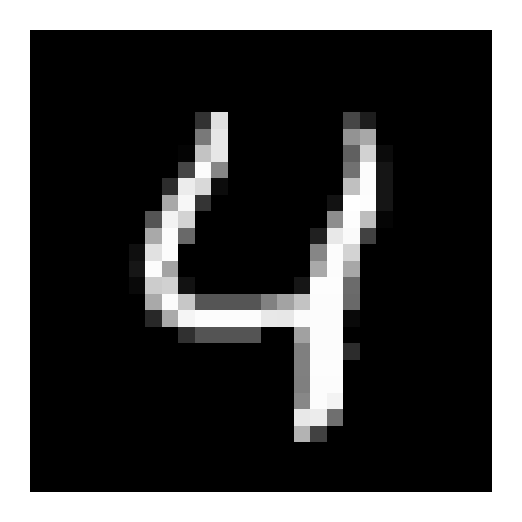

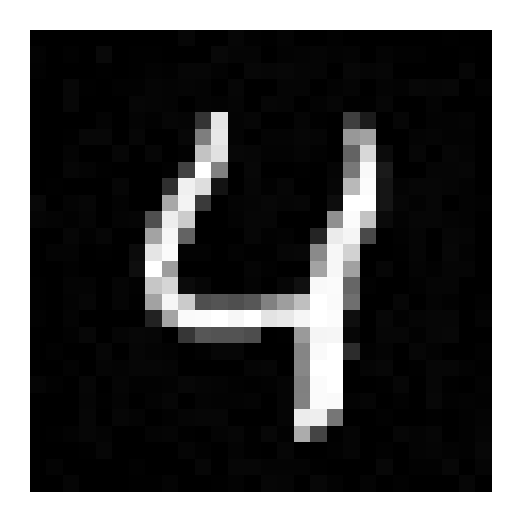

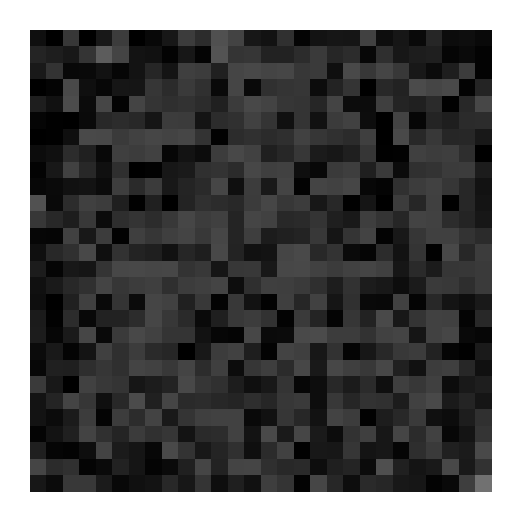

In [34]:
# plot the image with no axis values
plt.figure(figsize=(2, 2))
plt.imshow(x_mnist.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
# plot the adv image
plt.figure(figsize=(2, 2))
plt.imshow(x_adv.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
# plot the absolute difference in the same cmap scale
plt.figure(figsize=(2, 2))
plt.imshow(np.abs(x_mnist.reshape(28, 28) - x_adv.reshape(28, 28)), cmap='gray', vmin=0, vmax=.1)
plt.axis('off')

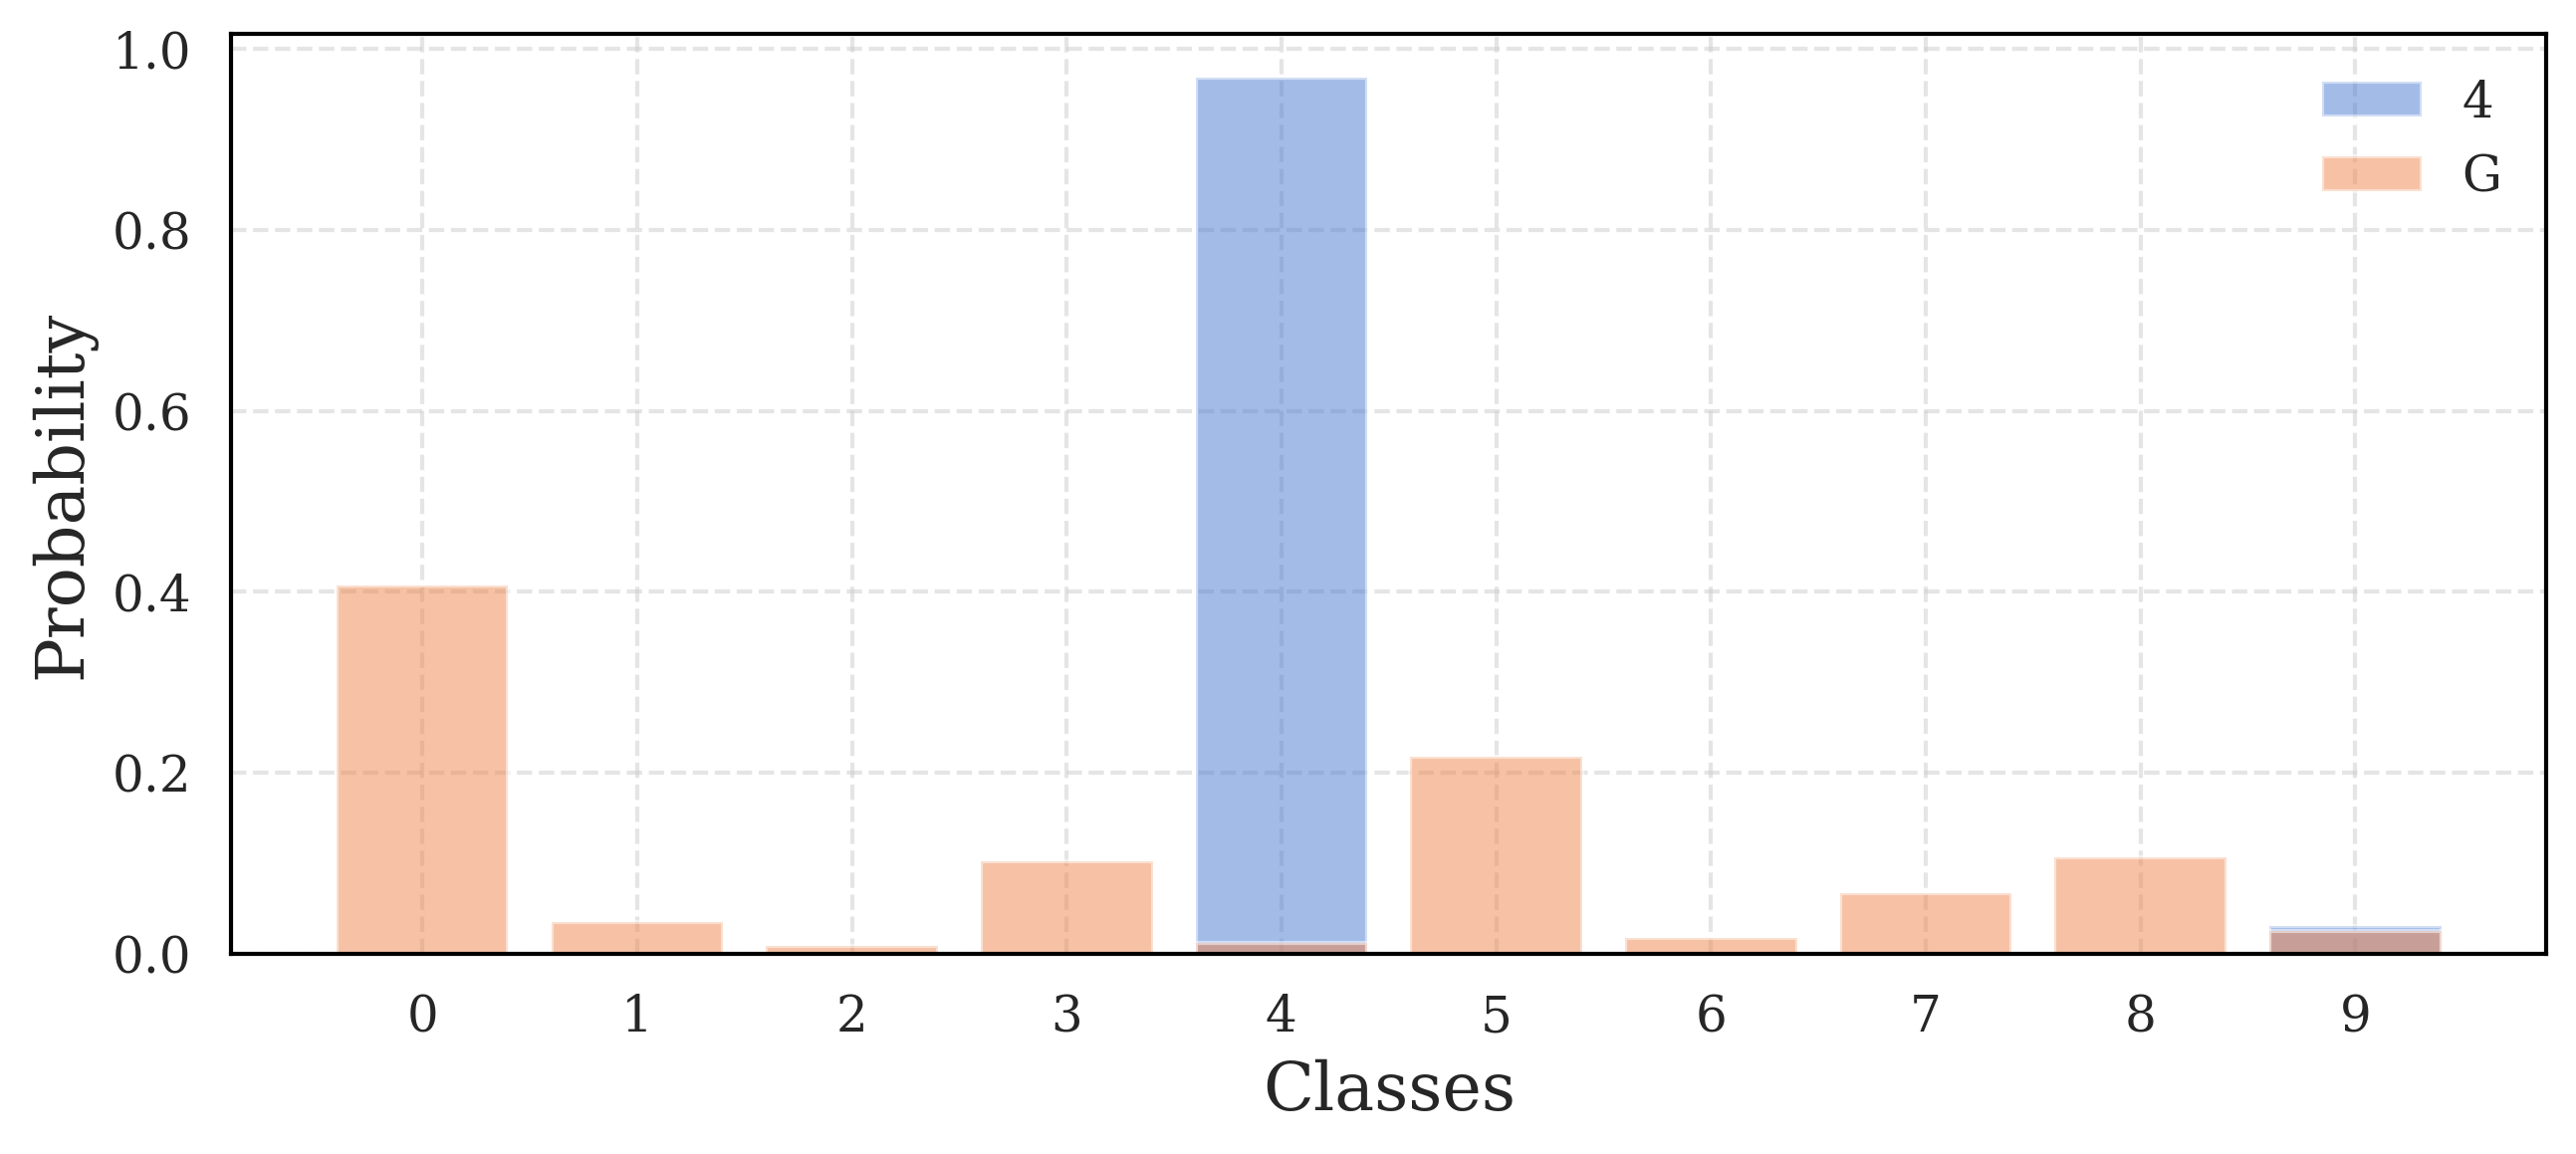

In [67]:
plt.figure(figsize=(10, 4))
plt.bar(x=jnp.arange(10), height=preds.mean(axis=0)[0], alpha=0.5, label='4')
plt.bar(x=jnp.arange(10), height=preds_not.mean(axis=0)[0], alpha=0.5, label='G')
# Add labels and all numbers for x-axis
plt.xticks(ticks=jnp.arange(10), labels=jnp.arange(10))
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.legend()

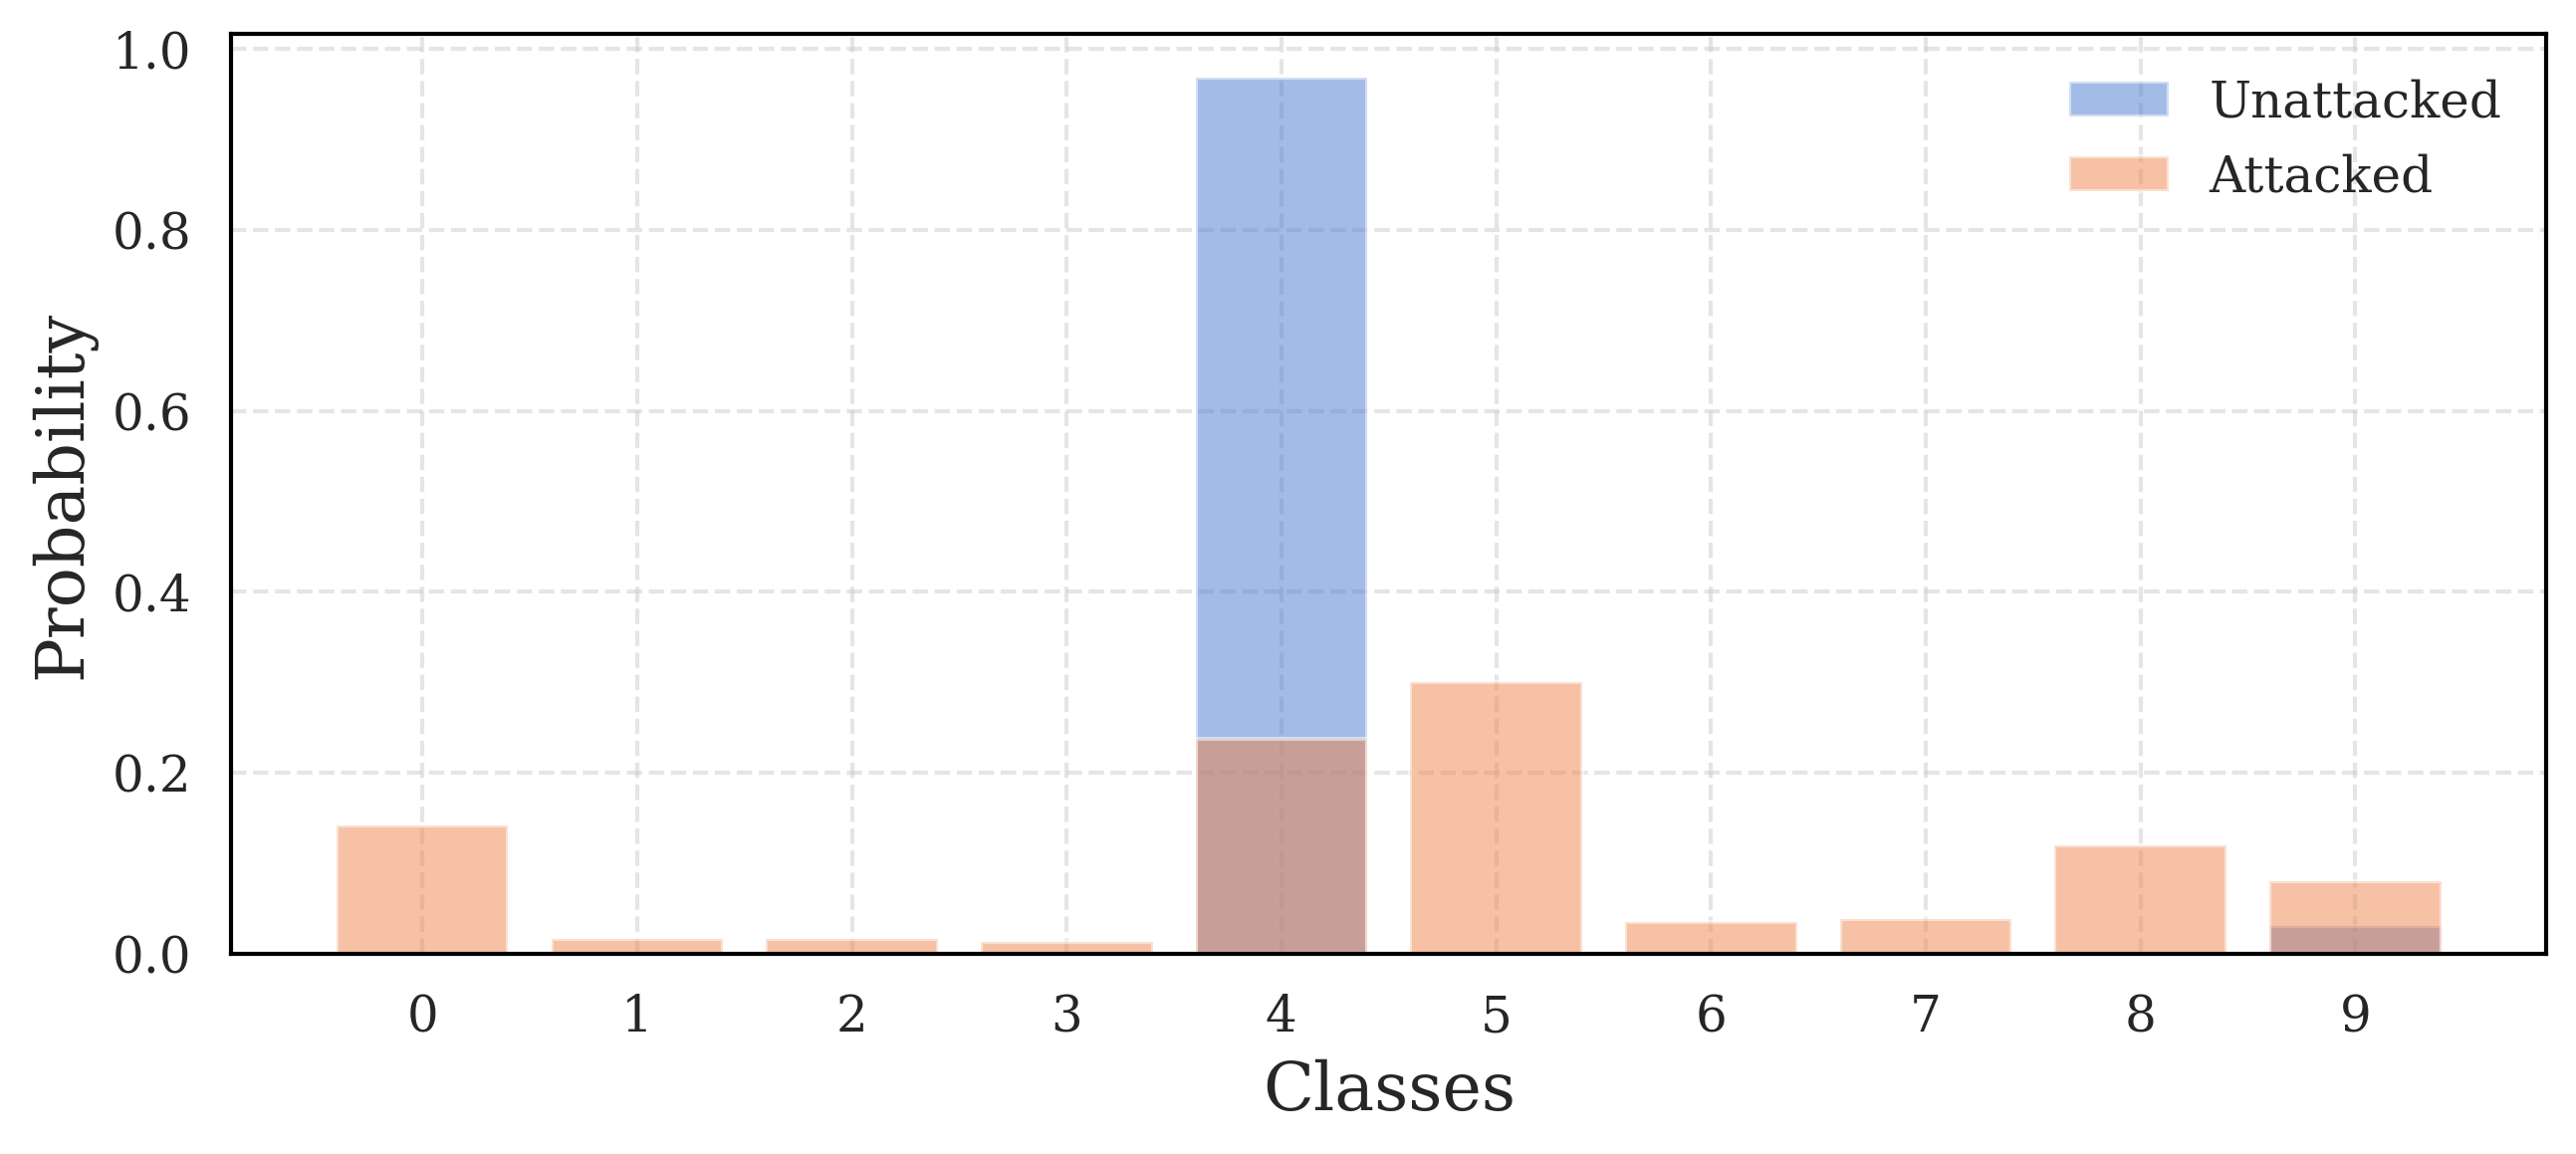

In [36]:
plt.figure(figsize=(10, 4))
plt.bar(x=jnp.arange(10), height=preds.mean(axis=0)[0], alpha=0.5, label='Unattacked')
plt.bar(x=jnp.arange(10), height=preds_adv.mean(axis=0)[0], alpha=0.5, label='Attacked')
# Add labels and all numbers for x-axis
plt.xticks(ticks=jnp.arange(10), labels=jnp.arange(10))
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.legend()

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

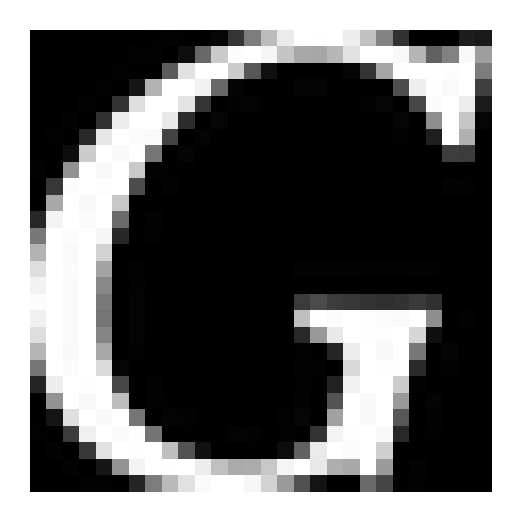

In [59]:
x_not = X_notmnist[2029]
x_not = jax.numpy.array(x_not.reshape(1, -1))
plt.figure(figsize=(2, 2))
plt.imshow(x_not.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')

In [ ]:
# attack the model with distributional attack
pred = preds_not.mean(axis=0).argmax(axis=-1)
pred = 7 # empirically works best 
obj_appd = numpyro.distributions.Categorical(probs=jax.nn.one_hot(pred, 10))

x_not_adv, _ = mlmc_attack(modelVI, x_not, appd=obj_appd, epsilon=.5, n_iter=400, lr=0.01)
preds_not_adv = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_not_adv, 20)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

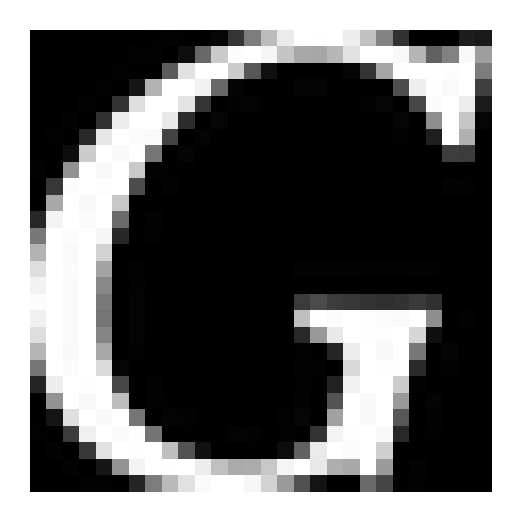

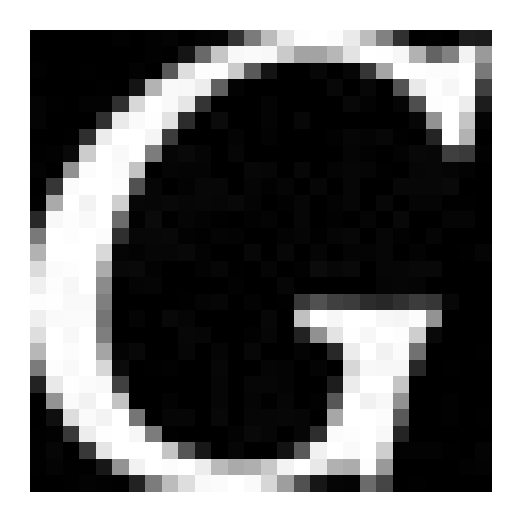

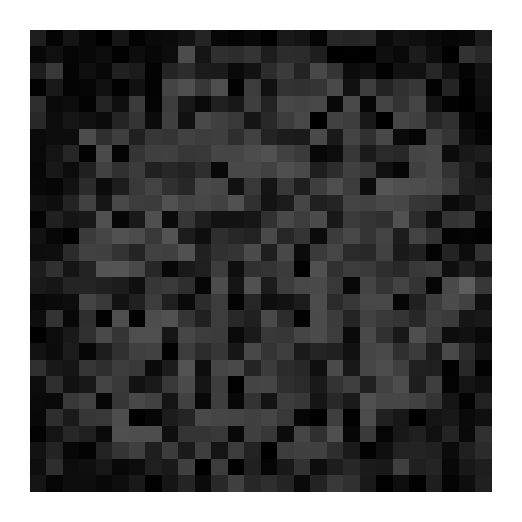

In [65]:
# plot the image with no axis values
plt.figure(figsize=(2, 2))
plt.imshow(x_not.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
# plot the adv image
plt.figure(figsize=(2, 2))
plt.imshow(x_not_adv.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')
# plot the absolute difference in the same cmap scale
plt.figure(figsize=(2, 2))
plt.imshow(np.abs(x_not.reshape(28, 28) - x_not_adv.reshape(28, 28)), cmap='gray', vmin=0, vmax=.1)
plt.axis('off')

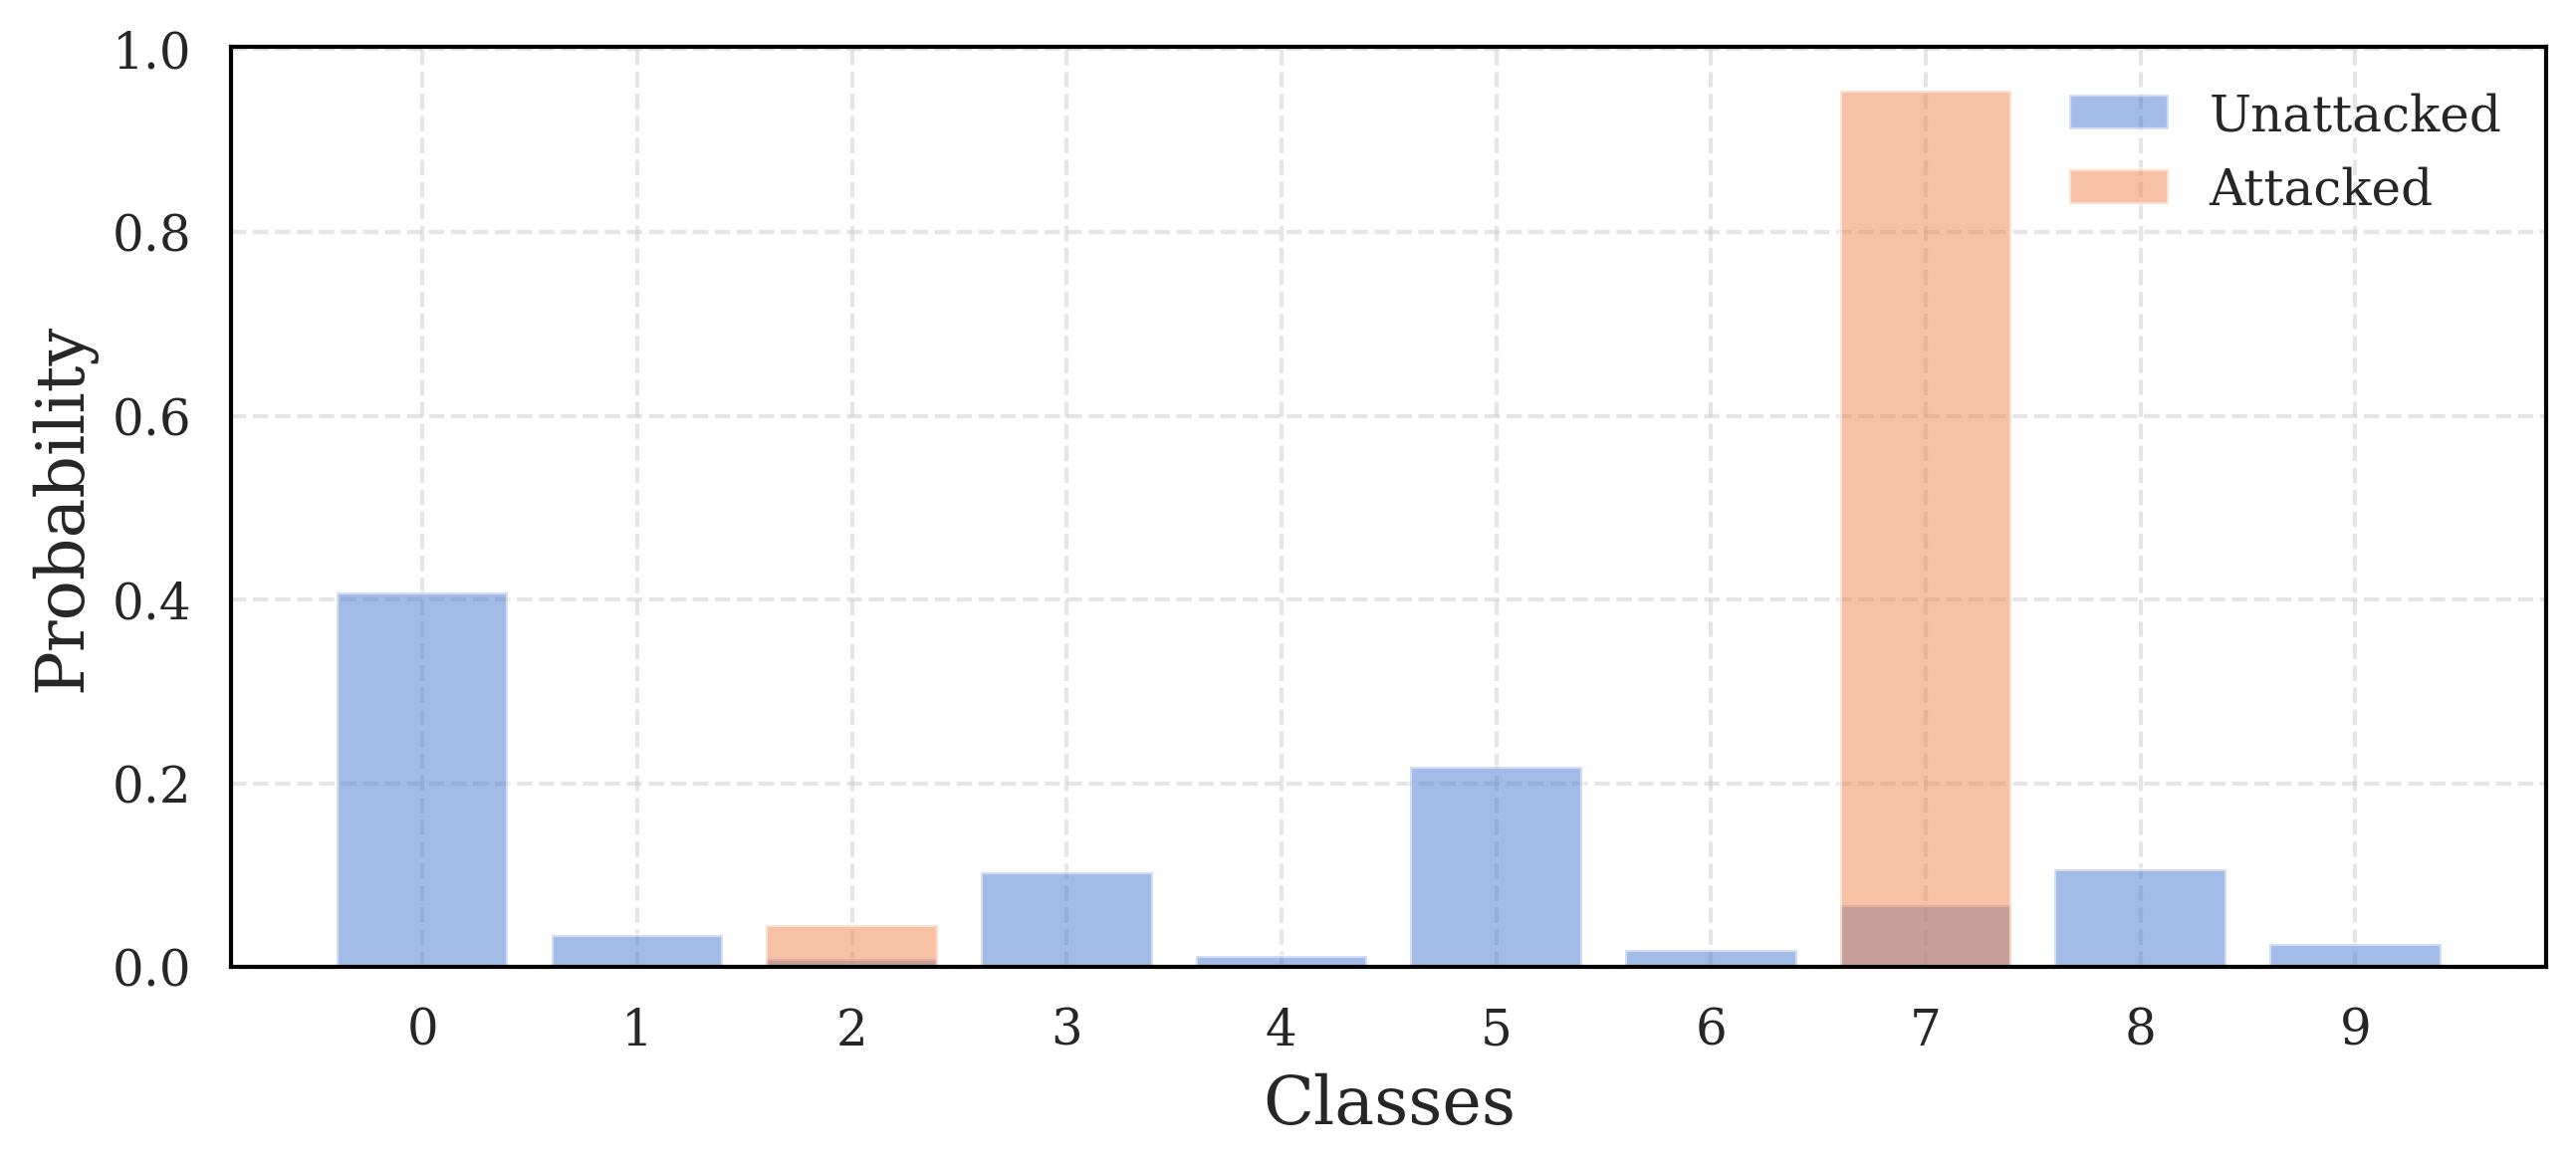

In [66]:
plt.figure(figsize=(10, 4))
plt.bar(x=jnp.arange(10), height=preds_not.mean(axis=0)[0], alpha=0.5, label='Unattacked')
plt.bar(x=jnp.arange(10), height=preds_not_adv.mean(axis=0)[0], alpha=0.5, label='Attacked')
# Add labels and all numbers for x-axis
plt.xticks(ticks=jnp.arange(10), labels=jnp.arange(10))
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.legend()

## Baseline

In [ ]:
unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))
plt.figure(figsize=(6, 4.5))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))
legend = ['MNIST', 'Not MNIST']
unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))
plt.legend(legend)
plt.xlabel('Entropy')

## Point attacks

In [ ]:
G = jnp.ones(10)/10  # we want to rise the entropy of the predictive distribution
plt.figure(figsize=(6, 4.5))
def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=identity, samples_per_iteration=1000, epsilon=eps, num_iterations=1000, learning_rate=0.01, mnist_vi=True)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)

unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))  

entropies_point_rise = []
for eps in epsilons:
    #entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    entropies = [process(x, eps) for x in tqdm(X_test[:num_points])]
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))
    entropies_point_rise.append(jnp.array(entropies))
np.save('results/entropies_point_rise.npy', jnp.array(entropies_point_rise))
    
legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons]
plt.legend(legend)

In [ ]:
G = 0  # we want to lower the entropy of the predictive distribution

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=entropy, samples_per_iteration=1000, epsilon=eps, num_iterations=1000, learning_rate=0.01, mnist_vi=True)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)
plt.figure(figsize=(6, 4.5))
unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))

entropies_point_lower = []
for eps in epsilons:
    #entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    entropies = [process(x, eps) for x in tqdm(X_notmnist[:num_points])]
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))
    entropies_point_lower.append(jnp.array(entropies))
np.save('results/entropies_point_lower.npy', jnp.array(entropies_point_lower))

legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons]
plt.legend(legend)

## Distribution attacks

In [ ]:
# Y is a uniform distribution over 10 classes
obj_appd = numpyro.distributions.Categorical(jnp.ones(10) / 10)

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400, lr=0.01)  # TODO DIFFERENT LR???
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)
plt.figure(figsize=(6, 4.5))
unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))

entropies_dist_rise = []
for eps in epsilons:
    #entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_test[:80]))
    entropies = [process(x, eps) for x in tqdm(X_test[:num_points])]
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))
    entropies_dist_rise.append(jnp.array(entropies))
np.save('results/entropies_dist_rise.npy', jnp.array(entropies_dist_rise))
    
legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons]
plt.legend(legend)

In [ ]:
def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    pred = modelVI.sample_predictive_distribution(jax.random.PRNGKey(0), x, 1)  # so obj_appd is just 1 point mass on pred
    obj_appd = numpyro.distributions.Categorical(probs=jax.nn.one_hot(pred, 10))
    
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)
plt.figure(figsize=(6, 4.5))
unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))

entropies_dist_lower = []
for eps in epsilons:
    #entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_notmnist[:8]))  # TODO 80 points
    entropies = [process(x, eps) for x in tqdm(X_notmnist[:num_points])]
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))
    entropies_dist_lower.append(jnp.array(entropies))
np.save('results/entropies_dist_lower.npy', jnp.array(entropies_dist_lower))

legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons]
plt.legend(legend)

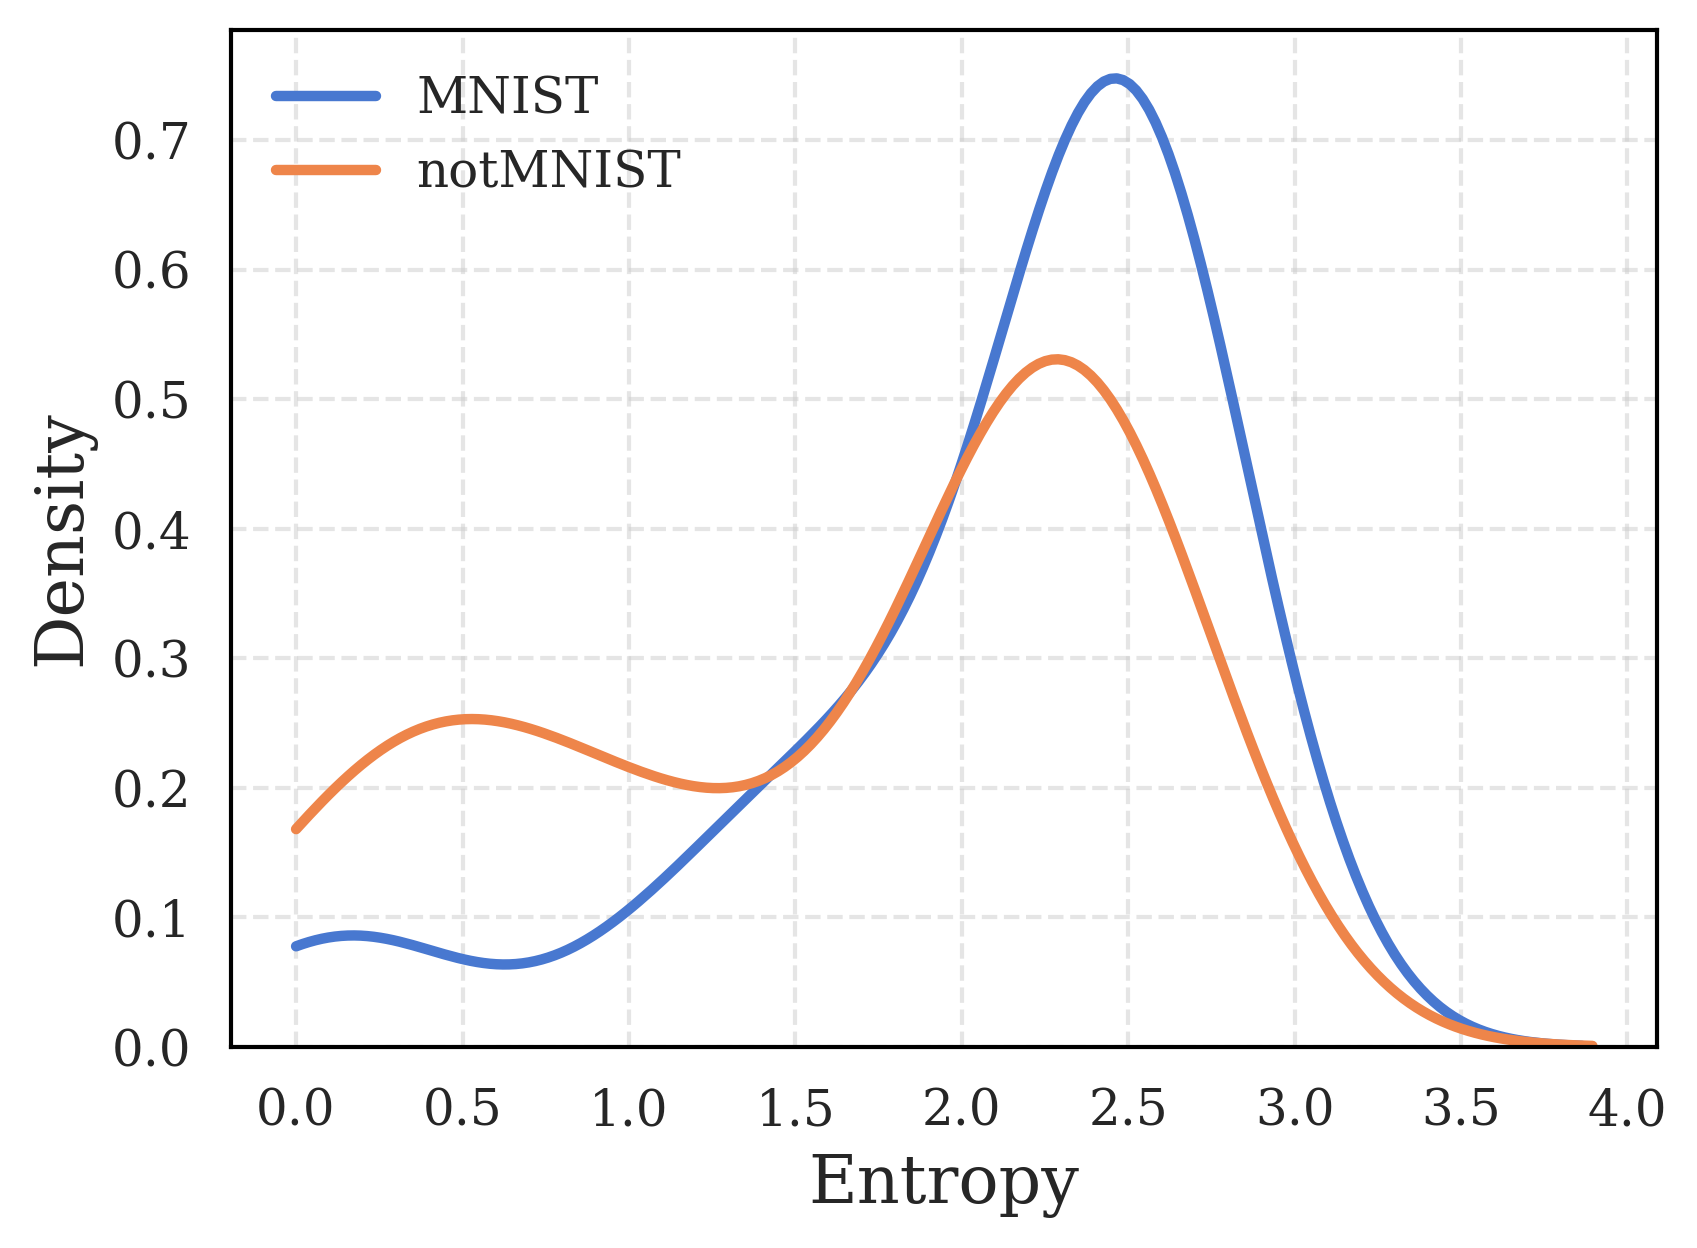

In [16]:
entropies_dist_rise = np.load('results_mnist/entropies_dist_rise.npy')
entropies_dist_lower = np.load('results_mnist/entropies_dist_lower.npy')

# Find the index corresponding to epsilon = 0.5
eps_index = epsilons.index(0.5)

# Extract entropy values at epsilon = 0.5
rise_eps05 = entropies_dist_rise[eps_index]
lower_eps05 = entropies_dist_lower[eps_index]

# Plot both KDEs on the same plot
plt.figure(figsize=(6, 4.5))
sns.kdeplot(rise_eps05, label='MNIST', clip=(0, 10))
sns.kdeplot(lower_eps05, label='notMNIST', clip=(0, 10))

plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Security eval plot

In [ ]:
num_points = 40

In [ ]:
entropies_point_lower = np.load('results_mnist/entropies_point_lower.npy')
entropies_point_rise = np.load('results_mnist/entropies_point_rise.npy')
entropies_dist_lower = np.load('results_mnist/entropies_dist_lower.npy')
entropies_dist_rise = np.load('results_mnist/entropies_dist_rise.npy')

entropies_point_lower_mean = entropies_point_lower.mean(axis=1)
entropies_point_rise_mean = entropies_point_rise.mean(axis=1)
entropies_dist_lower_mean = entropies_dist_lower.mean(axis=1)
entropies_dist_rise_mean = entropies_dist_rise.mean(axis=1)

zero_eps_entropy = np.array([entropy(x, modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)) for x in X_test[:num_points]]).mean()
zero_eps_entropy_notmnist = np.array([entropy(x, modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)) for x in X_notmnist[:num_points]]).mean()

entropies_point_lower_mean = np.concatenate([[zero_eps_entropy_notmnist], entropies_point_lower_mean])
entropies_point_rise_mean = np.concatenate([[zero_eps_entropy], entropies_point_rise_mean])
entropies_dist_lower_mean = np.concatenate([[zero_eps_entropy_notmnist], entropies_dist_lower_mean])
entropies_dist_rise_mean = np.concatenate([[zero_eps_entropy], entropies_dist_rise_mean])
epsilons_full = np.concatenate([[0], epsilons])
plt.figure(figsize=(6, 4.5))
plt.plot(epsilons_full, entropies_point_lower_mean)
plt.plot(epsilons_full, entropies_point_rise_mean)
plt.plot(epsilons_full, entropies_dist_lower_mean)
plt.plot(epsilons_full, entropies_dist_rise_mean)
plt.legend(['Alg.1 notMNIST', 'Alg.1 MNIST', 'Alg.2 notMNIST', 'Alg.2 MNIST'])
plt.xlabel('$\epsilon$')
plt.ylabel('Entropy')
plt.show()

## Accuracy with out-of-distribution detection for eps=.5

In [ ]:
for i in tqdm(range(100)):
    x = X_test[i]
    x = jax.numpy.array(x.reshape(1, -1))
    x_advs, _, _ = attack(x, modelVI, 20, func=entropy, samples_per_iteration=1000, epsilon=.5, num_iterations=100, learning_rate=0.01, mnist_vi=True)
    np.save(f'xs/x_test_attacked_{i}.npy', x_advs[-1])

for i in tqdm(range(100)):
    x = X_notmnist[i]
    x = jax.numpy.array(x.reshape(1, -1))
    x_advs, _, _ = attack(x, modelVI, 0, func=entropy, samples_per_iteration=1000, epsilon=.5, num_iterations=100, learning_rate=0.01, mnist_vi=True)
    np.save(f'xs/x_notmnist_attacked_{i}.npy', x_advs[-1])

In [ ]:
# For a mixed dataset with 50 points from each dataset, we can calculate the entropy of the predictive distribution
# and plot the accuracy of the model over the points with top n% lowest entropy

ns = np.linspace(1, .01, 11)
n_points = 50

X_test_attacked = jnp.concatenate([np.load(f'xs/x_test_attacked_{i}.npy') for i in range(100)])
X_notmnist_attacked = jnp.concatenate([np.load(f'xs/x_notmnist_attacked_{i}.npy') for i in range(100)])
num_reps = 5
accs_reps = []
accs_attacked_reps = []
for reps in range(num_reps):
    idx = np.random.choice(100, n_points)
    X_mixed = np.concatenate([X_test[idx], X_notmnist[idx]])
    X_mixed_attacked = np.concatenate([X_test_attacked[idx], X_notmnist_attacked[idx]])
    y_mixed = np.concatenate([y_test[idx].argmax(axis=1), -np.ones(n_points)])

    entropies = np.array([entropy(x, modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 100)) for x in X_mixed])
    entropies_attacked = np.array([entropy(x, modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 100)) for x in X_mixed_attacked])
    ord_idx = np.argsort(entropies)
    ord_idx_attacked = np.argsort(entropies_attacked)

    accs = []
    accs_attacked = []
    for n in ns:
        idx = ord_idx[:int(n * n_points * 2)]
        idx_attacked = ord_idx_attacked[:int(n * n_points * 2)]

        X_mixed_sel_clean = X_mixed[idx]
        y_mixed_sel_clean = y_mixed[idx]

        y_pred_clean = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), X_mixed_sel_clean, 100).mean(axis=0).argmax(axis=-1)
        clean_accuracy = (y_pred_clean == y_mixed_sel_clean).mean()
        accs.append(clean_accuracy)

        X_mixed_sel_att = X_mixed_attacked[idx_attacked]
        y_mixed_sel_att = y_mixed[idx_attacked]

        y_pred_att = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), X_mixed_sel_att, 100).mean(axis=0).argmax(axis=-1)
        att_accuracy = (y_pred_att == y_mixed_sel_att).mean()
        accs_attacked.append(att_accuracy)

    accs_reps.append(accs)
    accs_attacked_reps.append(accs_attacked)

accs_reps = np.array(accs_reps)
accs_attacked_reps = np.array(accs_attacked_reps)

In [ ]:
plt.figure(figsize=(6, 4.5))
plt.plot(100*ns, accs_reps.mean(axis=0), label='Unattacked')
plt.fill_between(100*ns, accs_reps.mean(axis=0) - 2*accs_reps.std(axis=0)/np.sqrt(num_reps), accs_reps.mean(axis=0) + 2*accs_reps.std(axis=0)/np.sqrt(num_reps), alpha=.3)
plt.plot(100*ns, accs_attacked_reps.mean(axis=0), label='Attacked')
plt.fill_between(100*ns, accs_attacked_reps.mean(axis=0) - 2*accs_attacked_reps.std(axis=0)/np.sqrt(num_reps), accs_attacked_reps.mean(axis=0) + 2*accs_attacked_reps.std(axis=0)/np.sqrt(num_reps), alpha=.3)
plt.legend()
plt.xlabel('Percentage of points accepted')
plt.ylabel('Accuracy')